In [102]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as sts



from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, auc, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.utils import class_weight
from sklearn.preprocessing import label_binarize
from sklearn.neighbors import KNeighborsClassifier



from scipy import stats
from prettytable import PrettyTable

In [103]:
data = pd.read_csv('data.csv')

Function for scores and ROC curve with corss-validation

In [104]:
def scores(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    return accuracy, precision, recall, f1

In [105]:

def perso_roc(test, X, y):
    y_pred_proba_cv = cross_val_predict(test, X, y, cv=5, method='predict_proba')

    # Compute the ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = len(np.unique(y))
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve((y == i).astype(int), y_pred_proba_cv[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot the ROC curves for each class
    plt.figure()
    colors = plt.cm.get_cmap('tab10', n_classes)
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], color=colors(i), label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) - OvR')
    plt.legend(loc='lower right')

### PCA Feature Selection

In [106]:
X = data.drop('metric_item_label', axis = 1)
y = data['metric_item_label']

In [107]:
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

In [108]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [109]:
data_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
data_pca['metric_item_label'] = y

In [110]:
unique_labels = data_pca['metric_item_label'].unique()
num_labels = len(unique_labels)
colors = plt.cm.get_cmap('viridis', num_labels)

In [111]:
label_color_map = dict(zip(unique_labels, colors(range(num_labels))))

In [112]:
column_name_mapping = {
    0: 'Deaths from All Causes',
    1: 'Firearm Deaths',
    2: 'Infant Deaths',
    3: 'Injury Deaths',
    4: 'Maternal Deaths',
    5: 'Motor Vehicle Deaths',
    6: 'Premature Death',
}

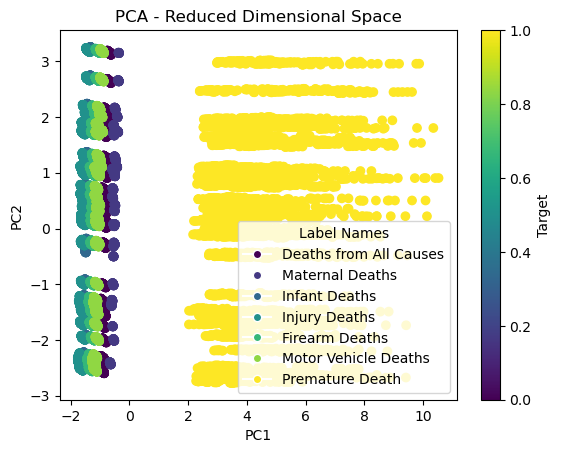

In [113]:
scatter = plt.scatter(data_pca['PC1'], data_pca['PC2'], c=data_pca['metric_item_label'].map(label_color_map), cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA - Reduced Dimensional Space')
plt.colorbar(scatter, label='Target')

legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=column_name_mapping[label], markerfacecolor=color) for label, color in label_color_map.items()]
plt.legend(handles=legend_elements, title='Label Names')

### Random Forest Model

In [114]:

y = data['metric_item_label']

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

Changing Hyperparameters

In [116]:
RF = RandomForestClassifier(n_estimators=5, max_depth=3, max_samples=20)
RF.fit(X_train, y_train)
y_pred_RF = RF.predict(X_test)

In [117]:
y_pred_proba_rf = RF.predict_proba(X_test) 
auc_RF = roc_auc_score(y_test, y_pred_proba_rf, multi_class='ovr')
print(f"Random Forest AUC: {auc_RF}")

Random Forest AUC: 0.8044626614517967


In [118]:
accuracy_RF, precision_RF, recall_RF, f1_RF = scores(y_test, y_pred_RF)

print(f"Accuracy: {accuracy_RF}")
print(f"Precision: {precision_RF}")
print(f"Recall: {recall_RF}")
print(f"F1 Score: {f1_RF}")

Accuracy: 0.7234242709313264
Precision: 0.6911988241088205
Recall: 0.7234242709313264
F1 Score: 0.6799223559591332


/Users/charlottekohler/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


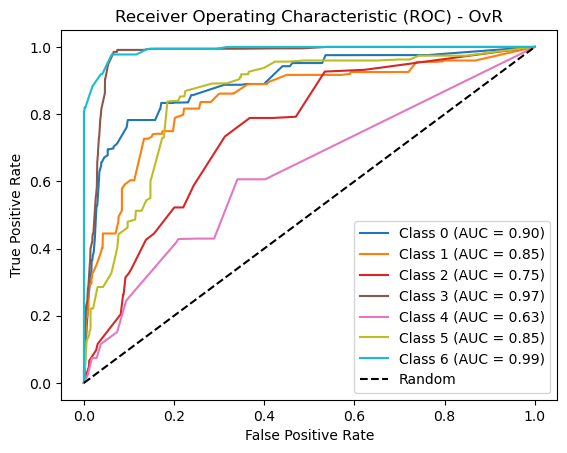

In [119]:
perso_roc(RF, X_pca, y)

### Logistic Regression Model

In [120]:
LogReg = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=3, penalty='l2', C=100)

In [121]:
LogReg.fit(X_train, y_train)
y_pred_LogReg = LogReg.predict(X_test)

/Users/charlottekohler/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [122]:
y_pred_proba_LR = LogReg.predict_proba(X_test) 
auc_LogReg = roc_auc_score(y_test, y_pred_proba_LR, multi_class='ovr')
print(f"Random Forest AUC: {auc_LogReg}")

Random Forest AUC: 0.9771014457784214


In [123]:
accuracy_LogReg, precision_LogReg, recall_LogReg, f1_LogReg = scores(y_test, y_pred_LogReg)

print(f"Accuracy: {accuracy_LogReg}")
print(f"Precision: {precision_LogReg}")
print(f"Recall: {recall_LogReg}")
print(f"F1 Score: {f1_LogReg}")

Accuracy: 0.8859830667920978
Precision: 0.8297587638074724
Recall: 0.8859830667920978
F1 Score: 0.853923746994563


/Users/charlottekohler/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/Users/charlottekohler/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/charlottekohler/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/charlottekohler/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/charlottekohler/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/charlottekohler/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


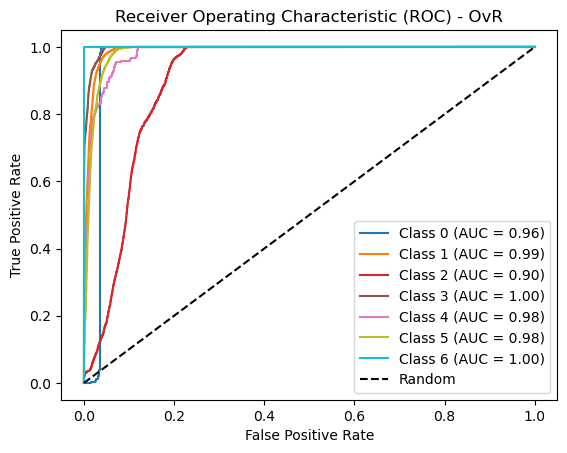

In [124]:
perso_roc(LogReg, X_pca, y)

### Decision Tree Model

In [125]:
DT = DecisionTreeClassifier(max_depth=3, min_samples_split=10)
DT.fit(X_train ,y_train)

y_pred_DT = DT.predict(X_test)

In [126]:
y_pred_proba_DT = DT.predict_proba(X_test) 
auc_DT = roc_auc_score(y_test, y_pred_proba_DT, multi_class='ovr')
print(f"Random Forest AUC: {auc_DT}")

Random Forest AUC: 0.9321835129636215


In [127]:
accuracy_DT, precision_DT, recall_DT, f1_DT = scores(y_test, y_pred_DT)

print(f"Accuracy: {accuracy_DT}")
print(f"Precision: {precision_DT}")
print(f"Recall: {recall_DT}")
print(f"F1 Score: {f1_DT}")

Accuracy: 0.7495766698024459
Precision: 0.619795802735611
Recall: 0.7495766698024459
F1 Score: 0.6707613168603237


/Users/charlottekohler/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


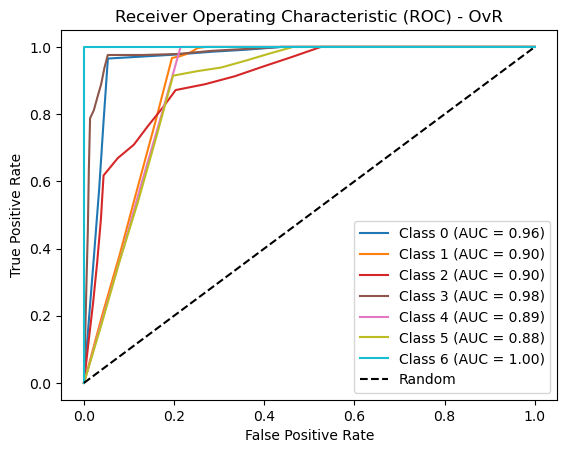

In [128]:
perso_roc(DT, X_pca, y)

### Using KNN model

In [129]:
knn = KNeighborsClassifier(n_neighbors=5000, algorithm='kd_tree')

knn.fit(X_train, y_train)
auc_knn = roc_auc_score(y_test, y_pred_proba_DT, multi_class='ovr')

y_pred_knn = knn.predict(X_test)

/Users/charlottekohler/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [130]:
accuracy_knn, precision_knn, recall_knn, f1_knn = scores(y_test, y_pred_knn)

print(f"Accuracy: {accuracy_knn}")
print(f"Precision: {precision_knn}")
print(f"Recall: {recall_knn}")
print(f"F1 Score: {f1_knn}")


Accuracy: 0.6199435559736595
Precision: 0.6660784453196263
Recall: 0.6199435559736595
F1 Score: 0.4985374181393162


/Users/charlottekohler/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


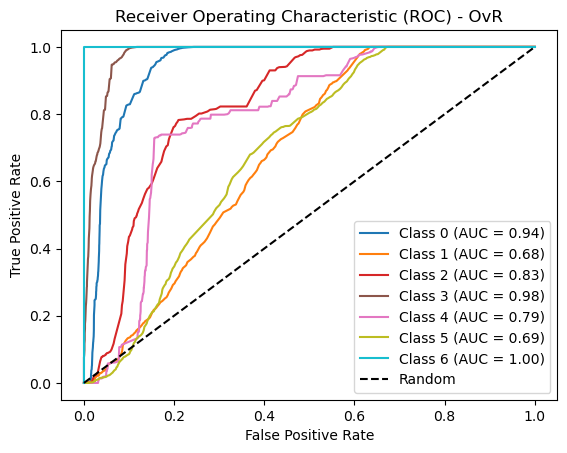

In [131]:
perso_roc(knn, X_pca, y)

### Scores

In [132]:
model_names = ['RF', 'LogReg', 'SVC', 'DT']
accuracy_scores = [accuracy_RF, accuracy_LogReg, accuracy_knn, accuracy_DT]
precision_scores = [precision_RF, precision_LogReg, precision_knn, precision_DT]
recall_scores = [recall_RF, recall_LogReg, recall_knn, recall_DT]
f1_scores = [f1_RF, f1_LogReg, f1_knn, f1_DT]

metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

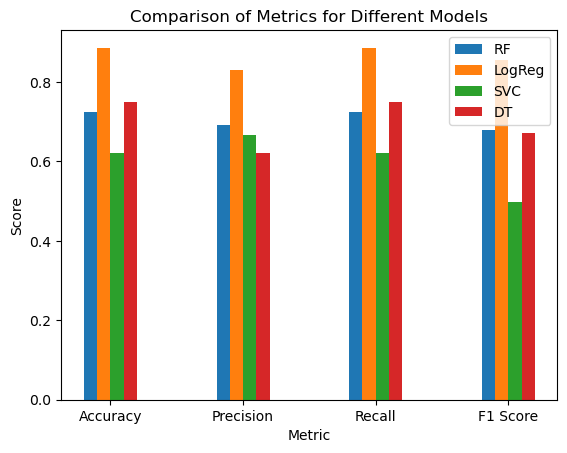

In [133]:
x = np.arange(len(metric_names))

bar_width = 0.1

fig, ax = plt.subplots()

for i, model_name in enumerate(model_names):
    model_scores = [accuracy_scores[i], precision_scores[i], recall_scores[i], f1_scores[i]]
    bar_positions = x + (i * bar_width)
    ax.bar(bar_positions, model_scores, bar_width, label=model_name)

ax.set_xlabel('Metric')
ax.set_ylabel('Score')
ax.set_title('Comparison of Metrics for Different Models')
ax.set_xticks(x + (bar_width * 1.5))
ax.set_xticklabels(metric_names)
ax.legend()

In [134]:
models = ['Random Forest', 'Decision Tree', 'Logistic Regression', 'KNN']
auc_values = [auc_RF, auc_DT, auc_LogReg, auc_knn]

Random Forest AUC: 0.9206823137035912
Decision Tree AUC: 0.9728597274202508
Logistic Regression AUC: 0.9800371573615442


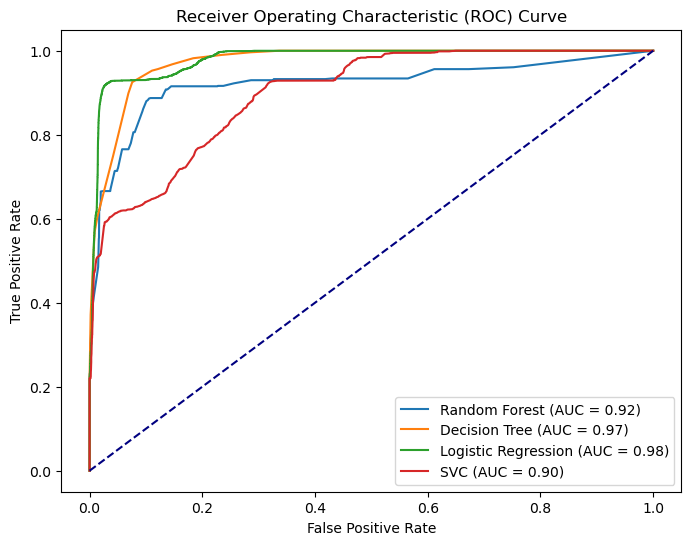

In [135]:
# Random Forest
y_pred_rf = RF.predict_proba(X_test)  # Assuming rf is your trained Random Forest model
fpr_rf, tpr_rf, _ = roc_curve(label_binarize(y_test, classes=np.unique(y_test)).ravel(), y_pred_rf.ravel())
auc_rf = auc(fpr_rf, tpr_rf)
print(f"Random Forest AUC: {auc_rf}")

# Decision Tree
y_pred_dt = DT.predict_proba(X_test)  # Assuming dt is your trained Decision Tree model
fpr_dt, tpr_dt, _ = roc_curve(label_binarize(y_test, classes=np.unique(y_test)).ravel(), y_pred_dt.ravel())
auc_dt = auc(fpr_dt, tpr_dt)
print(f"Decision Tree AUC: {auc_dt}")

# Logistic Regression
y_pred_lr = LogReg.predict_proba(X_test)  # Assuming lr is your trained Logistic Regression model
fpr_lr, tpr_lr, _ = roc_curve(label_binarize(y_test, classes=np.unique(y_test)).ravel(), y_pred_lr.ravel())
auc_lr = auc(fpr_lr, tpr_lr)
print(f"Logistic Regression AUC: {auc_lr}")

# SVC
decision_scores_svc = knn.predict_proba(X_test)
fpr_knn, tpr_knn, _ = roc_curve(label_binarize(y_test, classes=np.unique(y_test)).ravel(), decision_scores_svc.ravel())
auc_svc = auc(fpr_knn, tpr_knn)

# Plotting the ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.2f})")
plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC = {auc_dt:.2f})")
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {auc_lr:.2f})")
plt.plot(fpr_knn, tpr_knn, label=f"SVC (AUC = {auc_svc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
